In [170]:
import folium 
import requests
import wikipedia
import pandas as pd
import geopandas as gpd
import fiona
from bs4 import BeautifulSoup as bs

from shapely.geometry import Point

In [136]:
import os
os.environ['CURL_CA_BUNDLE'] = ""

import warnings
warnings.filterwarnings("ignore")

# List of Lost Manor Houses

Could web scrape this. This is just a list of the Bedfordhire houses
Data from - http://www.lostheritage.org.uk/lh_complete_list.html

In [130]:
prop = ['Ampthill House',
'Battlesden House',
'Bushmead Priory',
'Caddington Hall',
'Cranfield Court',
'Goldington Bury',
'Harrold Hall',
'Houghton House',
'Ickwell Bury',
'Kempston Hoo',
'Odell Castle',
'Pavenham Bury',
'Stockwood House',
'Stratton Park',
'Woburn Abbey']



# Wikipedia scraping
Need to do two stages:
1. Search for most likely URL using Property name
2. Extract geo corrdinates for this page
n.b. This has worked quite well on trial dataset, but are a couple of mismatched URLS that need manual check
Tutorial on using wikipedia package - https://stackabuse.com/getting-started-with-pythons-wikipedia-api/

In [188]:
# Proof of concept returnin web page
print(wikipedia.page(prop[1]).url)

https://en.wikipedia.org/wiki/Battlesden_House


In [138]:
# Find most appropriate URLs for property list
lst_url = []

for x in range(0,len(prop)):
    lst_url.append(wikipedia.page(prop[x]).url)

In [144]:
# Extract Coordinates for houses

lst_geo = []
popup = [] # popup showing URL for checking

for r in range(0, len(lst_url)):
    req = requests.get(lst_url[r],verify=False).text
    soup = bs(req, 'html')
    try:
        geo = soup.find("span", {"class": "geo"})
        #lst_geo.append([geo.text,lst_url[r]])
        lst_geo.append([float(geo.text.split(';')[0]),float(geo.text.split(';')[1])])
        popup.append(lst_url[r])
    except AttributeError:
        continue

In [195]:
# Visualise the points to check positioning
m =  folium.Map(location=(51.9831, -0.5968), zoom_start=10, tiles = 'cartodbpositron')


folium.TileLayer('https://api.maptiler.com/tiles/uk-osgb10k1888/{z}/{x}/{y}.jpg?key=ZKHfGhXtKWjlnbMXHATN',
        attr = "\u003ca href=\"http://maps.nls.uk/projects/subscription-api/\"\u003eNational Library of Scotland\u003c/a\u003e",
      ).add_to(m) # OS Historic mapping 1888 - 1903


ii = 0

for coordinates in lst_geo:
    
    folium.CircleMarker(
        location=coordinates,
        radius=4,
        fill=True,
        color='black',
        fill_color='black',
        popup = popup[ii]
    ).add_to(m)

    ii = ii+1

folium.LayerControl(collapsed=False).add_to(m)

In [196]:
m

In [164]:
df = pd.DataFrame(lst_geo, columns =["Lat","Long"])

<AxesSubplot:>

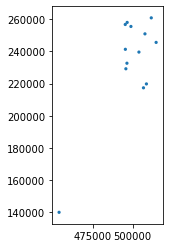

In [191]:
## Create a 1km radius arond each building for data retreival
# Could improve this to retrieve Title Info instead then building
geo_df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Long, df.Lat)).set_crs("EPSG:4326")
geo_df_b = geo_df.copy()
geo_df_b= geo_df_b.to_crs(epsg=27700)
geo_df_b['geometry'] = geo_df_b.buffer(1000)
geo_df_b.plot()

In [171]:
## Load OS building outline data
# OS Zoomstack is open source - IS 11gb and on my machine at present

gpkg = "C:\\Users\\culleyj\\Downloads\\OS_Open_Zoomstack\\OS_Open_Zoomstack.gpkg"
layers = fiona.listlayers(gpkg)
LB_gdf = gpd.read_file(r'C:\\Users\\culleyj\\Downloads\\OS_Open_Zoomstack\\OS_Open_Zoomstack.gpkg', layer='local_buildings')

In [192]:
## Interesct buffers and building outlines (n.b. Slooooow!)

sj = gpd.overlay(LB_gdf, geo_df_b, how='intersection', keep_geom_type=None)

In [199]:
sj = sj.to_crs(epsg=4326)

# Visualise the points to check positioning
m =  folium.Map(location=(51.9831, -0.5968), zoom_start=10, tiles = 'cartodbpositron')


folium.TileLayer('https://api.maptiler.com/tiles/uk-osgb10k1888/{z}/{x}/{y}.jpg?key=ZKHfGhXtKWjlnbMXHATN',
        attr = "\u003ca href=\"http://maps.nls.uk/projects/subscription-api/\"\u003eNational Library of Scotland\u003c/a\u003e",
      ).add_to(m) # OS Historic mapping 1888 - 1903


ii = 0

for coordinates in lst_geo:
    
    folium.CircleMarker(
        location=coordinates,
        radius=4,
        fill=True,
        color='black',
        fill_color='black',
        popup = popup[ii]
    ).add_to(m)

    ii = ii+1


folium.GeoJson(data=sj, name = 'Modern Buildings').add_to(m)
    
folium.LayerControl(collapsed=False).add_to(m)

m